In [1]:
from skimage import io, color, transform, util
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import maxabs_scale, minmax_scale
from skimage.feature import local_binary_pattern, greycomatrix, greycoprops
from skimage.filters import sobel
import pandas as pd
from sys import exit
warnings.filterwarnings('ignore')

%matplotlib inline

# IO functions

In [2]:
def load_images(dir, gray=False):
    images = pd.DataFrame()
    for path in dir:
        imgs_tmp = []
        labels = []
        for i, file in enumerate(os.listdir(path)):
            img = io.imread(os.path.join(path,file))
            img = transform.resize(img, (150, 150))
            if gray:
                img = color.rgb2gray(img)
            if img is not None:
                imgs_tmp.append(img)
                labels.append(file)            
        df = pd.DataFrame({'img':imgs_tmp, 'label':labels})
        df['class'] = [0 if path[-2] == 'n' else 1 for x in labels]
        images = images.append(df, ignore_index=True)
    return images

In [3]:
def save_images(dir, images, func = None, **params):
    try:
        for i in range(len(images)):
            image = images.iloc[i]['img']
            name = images.iloc[i]['label']
            clss = images.iloc[i]['class']

            path = dir[1] if clss else dir[0]
            if func is not None:
                io.imsave(os.path.join(path,name), func(image, **params))
            else:    
                io.imsave(os.path.join(path,name), image)
    except Exception as err:
        print(err)

In [4]:
def scale(img):
    return util.img_as_ubyte(img)

# Carregando datasets


In [5]:
base = '$/disciplinas/VISAOC/atividades/atv1/datasets/original/'
path = '$/disciplinas/VISAOC/atividades/atv1/datasets/'

In [6]:
datasets = {}
for dataset in os.listdir(path):
    local = base.replace('original',dataset)
    datasets[dataset] = load_images([local+'n/', local+'p/'], gray=True)

# Salvando datasets em disco

## lbp

In [7]:
def lbp(img, radius = 1):
    points = 8*radius
    x = img.copy()

    x = local_binary_pattern(x, points, radius)
    x, _ = np.histogram(x.ravel(), bins=np.arange(0,points+2), density=True)
    
    x = x.astype('float')
    return x

In [8]:
for dataset in datasets.keys():
    datasets[dataset]['lbp'] = [lbp(x, 2) for x in datasets[dataset]['img']]

## glcm

In [9]:
def glcm(img, patch_size, dist, angles):
    contrasts = []
    uint_img = scale(img.copy())

    for i in range(0, uint_img.shape[0], patch_size):
        for j in range(0, uint_img.shape[1], patch_size):
            tmp = greycomatrix(uint_img[i:i+patch_size,j:j+patch_size], dist, angles, normed=True)
            feature = greycoprops(tmp, 'contrast')
            contrasts.append(feature.ravel()[0])
    
    return np.array(contrasts)

In [10]:
for dataset in datasets.keys():
    datasets[dataset]['glcm'] = [glcm(x, 15, [1], [0]) for x in datasets[dataset]['img']]

## sobel

In [11]:
for dataset in datasets.keys():
    datasets[dataset]['sobel'] = [sobel(x).reshape(-1) for x in datasets[dataset]['img']]

## Salvando

In [12]:
for dataset in datasets.keys():
    datasets[dataset].to_pickle(f'{dataset}.pkl')

# Teste salvando / abrindo

In [92]:
#images['sobel'] =  [sobel(x).reshape(-1) for x in images['img']]
#images['glcm'] =  [glcm(x, 15, [1], [0]) for x in images['img']]
#images['lbp'] =  [lbp(x, 2) for x in images['img']]

In [93]:
#images.head()

In [94]:
#images.to_pickle('test.pkl')

In [19]:
#opened = pd.read_pickle('equalize_hist.pkl')
#opened.head()

In [20]:
#plt.imshow(opened['img'][0], cmap='gray')

In [21]:
#plt.imshow(opened['sobel'][0].reshape(150,150), cmap='gray')

In [22]:
#opened2 = pd.read_pickle('original.pkl')
#opened2.head()

In [23]:
#plt.imshow(opened2['img'][0], cmap='gray')

In [24]:
#plt.imshow(opened2['sobel'][0].reshape(150,150), cmap='gray')

# Relatorio

In [32]:
labels = ['Original', 'Equaliz. Hist.', 'Gamma Correction', 'Gaussian', 'Laplace']

In [27]:
#0 - original
#1 - equalize_hist
#2 - gamma_correction2
#3 - gaussian
#4 - laplace
features = ['original', 'equalize_hist', 'gamma_correction2', 'gaussian', 'laplace']
descriptors = ['lbp', 'glcm', 'sobel']
tests = []
for feature in features:
    tests.append(datasets[feature]['img'][0])

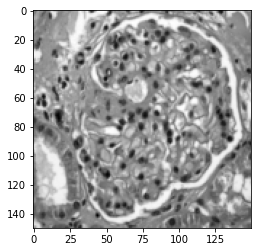

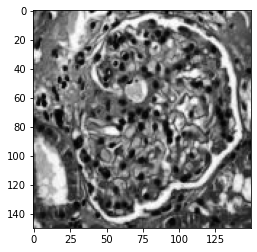

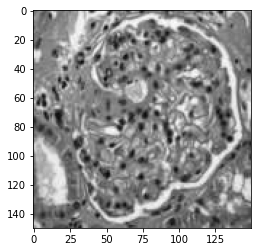

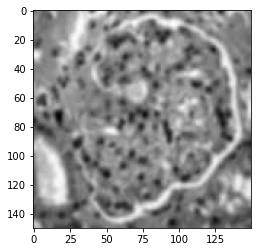

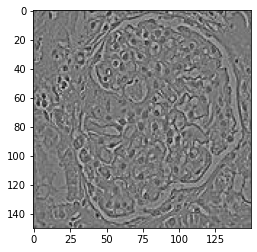

In [30]:
for el in tests:
    plt.imshow(el, cmap='gray')
    plt.show()

## LBP

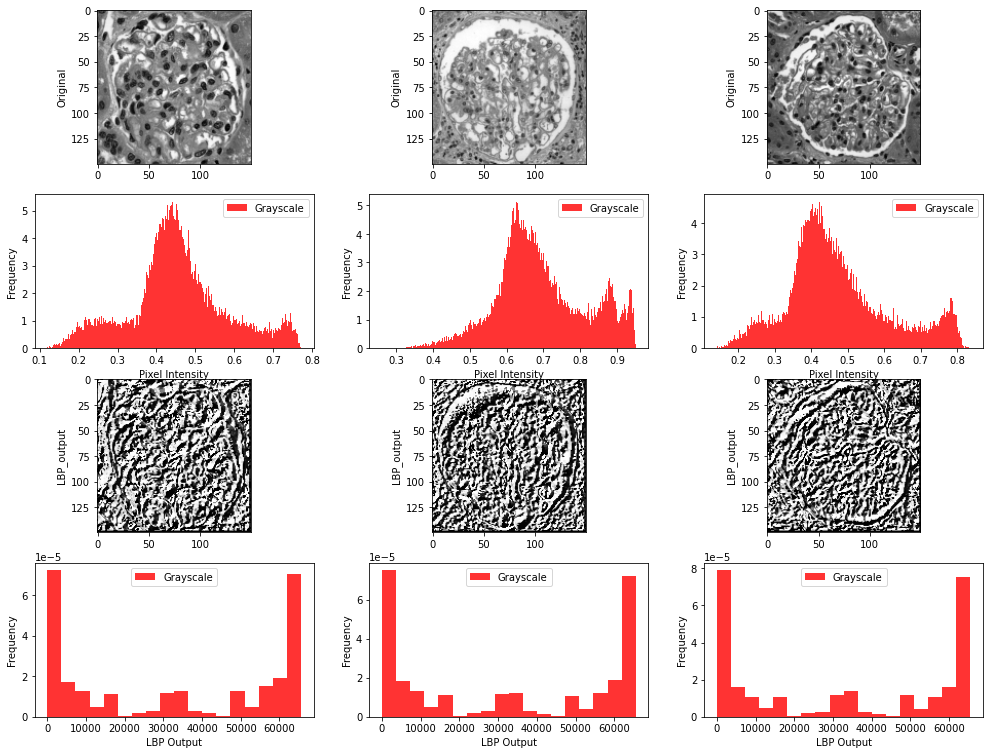

In [48]:
radius = 2
points = 8*radius
test1 = [datasets['original']['img'][10+x] for x in range(3)]

fig, axes = plt.subplots(4,3,figsize=(17,13))
for i, img in enumerate(test1):
    axes[0][i].imshow(img, cmap='gray')
    axes[0][i].set_ylabel('Original')

    axes[1][i].hist(img.ravel(), bins = 256, color = 'red', alpha = 0.8, density=True, label='Grayscale')
    axes[1][i].set_ylabel('Frequency')
    axes[1][i].set_xlabel('Pixel Intensity')
    axes[1][i].legend()


for i, img in enumerate(test1):
    x = img.copy()
    x = local_binary_pattern(x, points, radius)
    axes[2][i].imshow(x, cmap='gray')
    axes[2][i].set_ylabel('LBP_output')

    axes[3][i].hist(x.ravel(), bins = points+2, color = 'red', alpha = 0.8, density=True, label='Grayscale')
    axes[3][i].set_ylabel('Frequency')
    axes[3][i].set_xlabel('LBP Output')
    axes[3][i].legend()

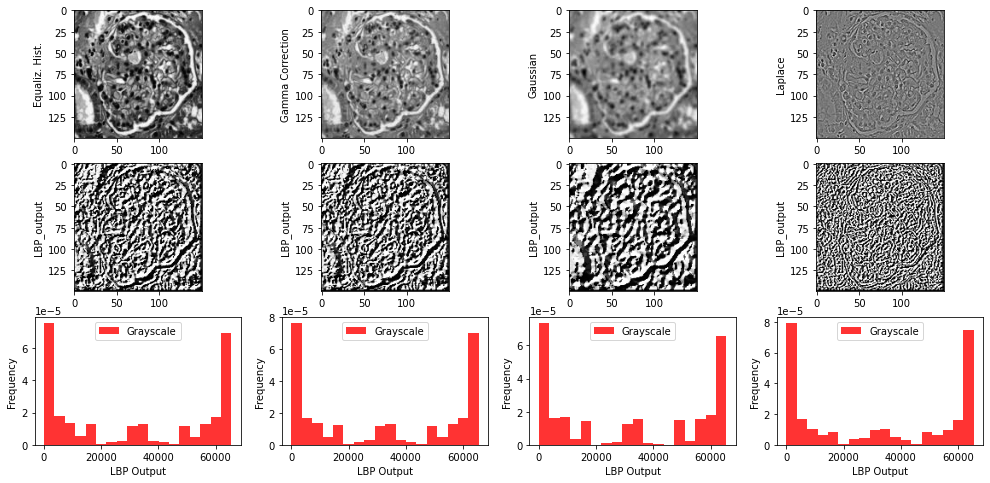

In [47]:
#labels = ['Original', 'Equaliz. Hist.', 'Gamma Correction', 'Gaussian', 'Laplace']
#tests.append(datasets[feature]['img'][0])
radius = 2
points = 8*radius
fig, axes = plt.subplots(3,4,figsize=(17,8))

for i in range(4):
    axes[0][i].imshow(tests[i+1], cmap='gray')
    axes[0][i].set_ylabel(labels[i+1])

for i in range(4):
    x = local_binary_pattern(tests[i+1], points, radius)
    axes[1][i].imshow(x, cmap='gray')
    axes[1][i].set_ylabel('LBP_output')

for i in range(4):
    x = local_binary_pattern(tests[i+1], points, radius)
    axes[2][i].hist(x.ravel(), color = 'red', bins=points+2 ,alpha = 0.8, density=True, label='Grayscale')
    axes[2][i].set_ylabel('Frequency')
    axes[2][i].set_xlabel('LBP Output')
    axes[2][i].legend()

## GLCM - Contrast

In [50]:
glcm_imgs = []

for img in tests:
    tmp_img = img.copy()
    tmp_img[:] = 0
    uint_img = scale(img.copy())
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if i<4 or j<4:
                continue
            if i>(img.shape[0]-5) or j>(img.shape[0]-5):
                continue
        
            tmp = greycomatrix(uint_img[i-4:i+5,j-4:j+5], [1], [0], normed=True)
            tmp_img[i,j] = greycoprops(tmp, 'contrast')
    glcm_imgs.append(tmp_img)

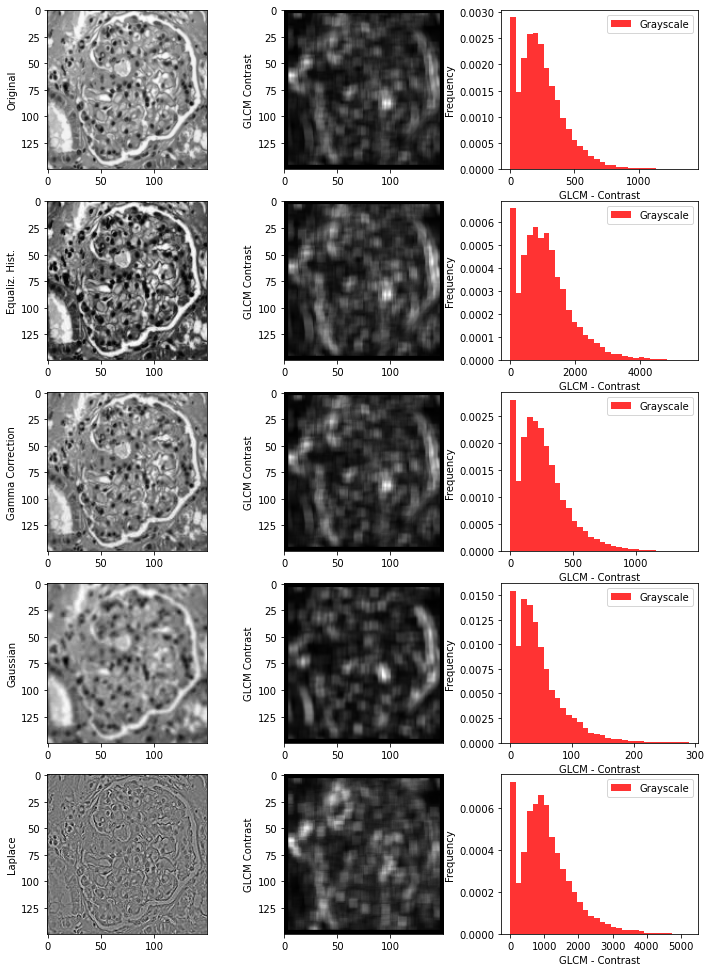

In [73]:
fig, axes = plt.subplots(5,3,figsize=(12,17))
for i, img in enumerate(tests):
    axes[i][0].imshow(img, cmap='gray')
    axes[i][0].set_ylabel(labels[i])


for i, img in enumerate(glcm_imgs):
    axes[i][1].imshow(img, cmap='gray')
    axes[i][1].set_ylabel('GLCM Contrast')

for i, img in enumerate(glcm_imgs):    
    axes[i][2].hist(img.ravel(), color = 'red', bins=32, alpha = 0.8, density=True, label='Grayscale')
    axes[i][2].set_ylabel('Frequency')
    axes[i][2].set_xlabel('GLCM - Contrast')
    axes[i][2].legend()


## Sobel

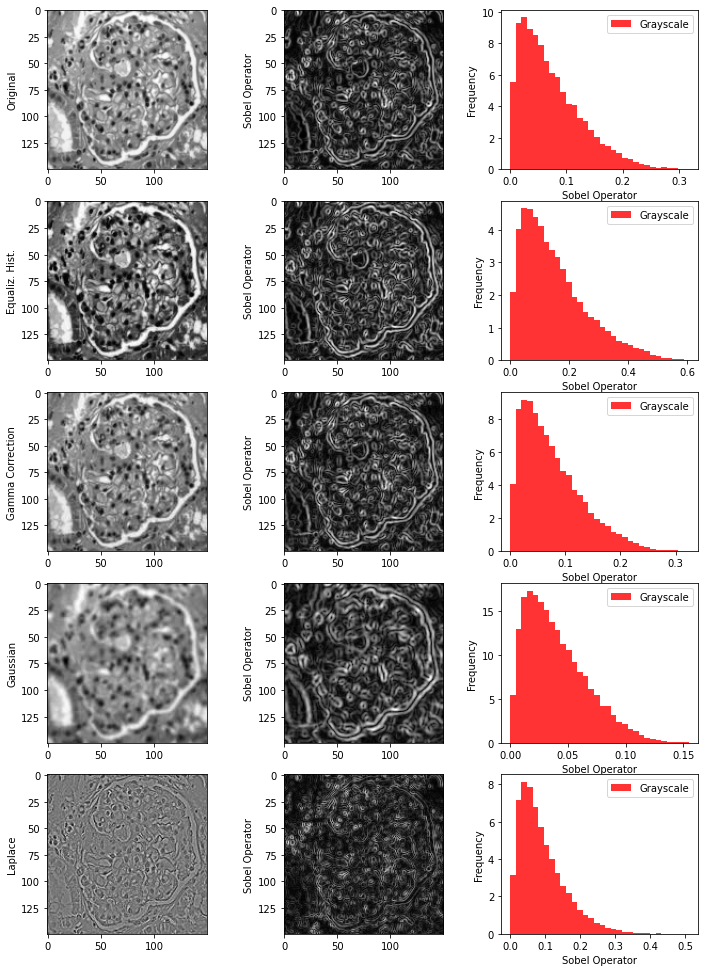

In [76]:
fig, axes = plt.subplots(5,3,figsize=(12,17))
for i, img in enumerate(tests):
    axes[i][0].imshow(img, cmap='gray')
    axes[i][0].set_ylabel(labels[i])


for i, img in enumerate(tests):
    axes[i][1].imshow(sobel(img), cmap='gray')
    axes[i][1].set_ylabel('Sobel Operator')

for i, img in enumerate(tests):    
    axes[i][2].hist(sobel(img).ravel(), color = 'red', bins=32, alpha = 0.8, density=True, label='Grayscale')
    axes[i][2].set_ylabel('Frequency')
    axes[i][2].set_xlabel('Sobel Operator')
    axes[i][2].legend()
